# Snapshots at peak intensity of
# A) mslp (contours), 10m wind (arrows), and 6hr precip (shading)
# and
# B) mslp (contours), 850 hPa wind speed (arrows), and 850 hPa spec hum (shading)
# at 80 km

Christoph Braun, 2023-05


for cases CTL, 4K, 4KqvCTL, Tanom

1 time step: peak intensity for each case determind by timestep with minimum pmin from cyclone tracks

2 combinations of vars (see headline)

native triangular grid

cyclone centered

### Load required libraries

In [40]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import xarray as xr
import numpy as np
import pandas as pd

from collections import defaultdict

from numba import njit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

### Define dicts to access data

In [41]:
#####################################################
# cyclone specific data
#####################################################
# channel_Xkm_0001: control simulations
# channel_Xkm_0002: +4K, qv consistent with T
# channel_Xkm_0003: +4k, qv from control
# channel_Xkm_0004: +temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0005: +tropical temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0006: +polar temperature anomaly from MPI-ESM1-2-LR far future

# Note that the  2-km experiments contain outputs every 6 hrs
# Note that the 80-km experiments contain outputs every 1 hrs


expname = {
      1: 'CTL',    
      2: 'T+4K',
      3: 'T+4K_RH-',
      4: 'T+anom',
      5: 'T+TRanom',
      6: 'T+POanom'
         }

exp80 = { 
      1:'channel_80km_0001',
      2:'channel_80km_0002',
      3:'channel_80km_0003',
      4:'channel_80km_0004',
      5:'channel_80km_0005',
      6:'channel_80km_0006',
      }

exp2 = { 
      1:'channel_2km_0001',
      2:'channel_2km_0002',
      3:'channel_2km_0003',
      4:'channel_2km_0004',
      5:'channel_2km_0005',
      6:'channel_2km_0006',
      }


### Set experiments to load data for

In [42]:
experiments  = [exp2[1],exp2[2],exp2[3],exp2[4],exp2[5],exp2[6],exp80[1],exp80[2],exp80[3],exp80[4],exp80[5],exp80[6]]

### Set domain parameters

In [43]:
# desired latitudinal extent of data
latmin = 20
latmax = 70

# longitudinal extent of data
lon_min=12.5
lon_ext=51
lon_max=lon_min+lon_ext

### Read in track data

In [44]:
def read_track_data(exp,track_dur,track_lon,track_lat,track_pmin):

    # path
    path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

    df_track = pd.read_csv(path_track+'Track_for_'+exp+'_6hrly_1x1latlon.csv')
    
    # extract vars of interest
    track_dur[exp]  = df_track['time']+1
    track_lon[exp]  = df_track['lon']
    track_lat[exp]  = df_track['lat']
    track_pmin[exp] = df_track['pmin']
    
    return track_dur,track_lon,track_lat,track_pmin

In [45]:
track_dur  = {}
track_lon  = {}
track_lat  = {}
track_pmin = {}

for exp in experiments:
    track_dur,track_lon,track_lat,track_pmin = read_track_data(exp,
                                                               track_dur,
                                                               track_lon,
                                                               track_lat,
                                                               track_pmin)

### Determine required shift of data in longitudinal direction for centering on location of pmin

In [46]:
def get_lon_shift(cen_lon):
    
    shift = lon_min + lon_ext/2 - cen_lon

    return shift

In [47]:
shift = defaultdict(dict)

for exp in experiments:
    shift[exp] = get_lon_shift(track_lon[exp])
    #print(shift[exp])

### Load raw simulation output

####  Helper function for loading data

In [48]:
def load_iconsimulation(expid):
    
    print('Working on loading data for', expid)
    # set path to data
    path  = '/work/bb1152/Module_A/A6_CyclEx/sim_data/production'
    # set path to grid
    gridpath = '/work/bb1152/Module_A/A6_CyclEx/input_data/'
    # set grid file
    
    # 2d datasets
    if (expid in list(exp80.values())):
        fname = path+'/'+expid+'/raw_data/icon-atm2d_ML_202101*Z.nc'
        gridfile = 'Channel_4000x9000_80000m_with_boundary.nc'
    else:
        fname = path+'/'+expid+'/icon-atm2d_ML_202101*Z.nc'
        gridfile = 'Channel_4000x9000_2500m_with_boundary.nc'
    print(fname)
    ds_2d = xr.open_mfdataset(fname).rename({'plev': 'plev_1'})
    
    # 3d datasets
    fname = path+'/'+expid+'/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc'
    print(fname)
    ds_3d = xr.open_mfdataset(fname)
    
    # grid dataset
    fname = gridpath+gridfile
    print(fname)
    ds_grid = ( xr.open_dataset(fname)
               [['cell_area','clat','clon','clon_vertices','clat_vertices',
                 'vlon','vlat','vertex_of_cell', 'vertex']].rename({'cell': 'ncells'}) ) 
    # we need to subtract -1 from vertex_of_cell as python starts counting at 0, but fortran starts at 1
    ds_grid['vertex_of_cell'] = ds_grid['vertex_of_cell'] - 1 
    
    # merge datasets
    ds = xr.merge([ds_2d, ds_3d, ds_grid])
        
    # convert grid from radians to degrees
    ds['clon'] = np.rad2deg(ds['clon'])
    ds['clat'] = np.rad2deg(ds['clat'])
    ds['vlon'] = np.rad2deg(ds['vlon'])
    ds['vlat'] = np.rad2deg(ds['vlat'])
    ds['clon_vertices'] = np.rad2deg(ds['clon_vertices'])
    ds['clat_vertices'] = np.rad2deg(ds['clat_vertices'])
    
    return ds

### Load data

In [49]:
ds = {}

for exp in experiments:
    ds[exp] = load_iconsimulation(exp)

Working on loading data for channel_2km_0001
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/icon-atm2d_ML_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/input_data/Channel_4000x9000_2500m_with_boundary.nc
Working on loading data for channel_2km_0002
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0002/icon-atm2d_ML_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0002/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/input_data/Channel_4000x9000_2500m_with_boundary.nc
Working on loading data for channel_2km_0003
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0003/icon-atm2d_ML_202101*Z.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0003/interpol_850hPa_qv_u_v_native/icon-qv_u_v_850hPa_202101*Z.nc
/work/bb1152/Module_A/

### Select required variables and timesteps

In [50]:
for exp in experiments:
    
    # Select required variables
    ds[exp] = ds[exp][['pres_msl',
                       'tot_prec',
                       'u_10m',
                       'v_10m',
                       #'qv', # at 850 hPa
                       #'u', # at 850 hPa
                       #'v', # at 850 hPa
                       'vlon','vlat','vertex_of_cell','clon_vertices']]
    
    # Adjust time axis
    ds[exp]['time'] = ds[exp]['time']-20210100
    
    # Reduce to 6-hourly data for 80km CTL sim
    if (exp in list(exp80.values())):
        ds[exp] = ds[exp].sel(time=np.arange(1,10.1,0.25))
        
    # Add 6-hourly precipiation to dataset
    # Prec. in kg m-2 
    ds[exp]['prec_6hrly'] = ds[exp]['tot_prec'].diff(dim='time')
    
    # Add 10m wind
    ds[exp]['wind_10m'] = np.sqrt(ds[exp]['u_10m'].isel(height=0)**2 + ds[exp]['v_10m'].isel(height=0)**2)
    
    # Add 850 hPa wind
    #ds[exp]['wind_850hPa'] = np.sqrt(ds[exp]['u'].isel(plev=0)**2 + ds[exp]['v'].isel(plev=0)**2)
    
    # Select desired timesteps
    #ds[exp] = ds[exp].sel(time=t_plot[exp])
    #ds[exp] = ds[exp].sel(time=np.arange(3,9,0.25))

### Reduce latitudinal range of data

In [51]:
def reduce_latrange(ds,latmin,latmax):
    icells = np.where((ds.clat<latmax) & (ds.clat>latmin))[0]
    ds = ds.isel(ncells=icells)
    
    return ds

In [52]:
def reduce_lonrange(ds,lonmin,lonmax):
    icells = np.where((ds.clon<lonmax) & (ds.clon>lonmin))[0]
    ds = ds.isel(ncells=icells)
    
    return ds

In [53]:
for exp in experiments:
    ds[exp] = reduce_latrange(ds[exp],latmin,latmax)

### Remove triangles that connect eastern and western domain boundary

In [54]:
@njit()
def get_indices_regular_triangles(clon_vertices):
    
    # determine number of triangles
    
    ntriang = np.shape(clon_vertices)[0]
    
    # required to make all values integer
    icells_regular = np.full(ntriang,-1,dtype=np.int64)
    
    for i in range(0,ntriang):
        if np.any(np.abs(clon_vertices[i]-np.mean(clon_vertices[i]))<1):
            icells_regular[i] = int(i)

    # required to remove first value, which is required to make all values integer
    icells_regular = icells_regular[np.where(icells_regular>=0)]
    
    return icells_regular

In [55]:
def remove_skewed_triangles(ds):

    # select indices
    icells_regular = get_indices_regular_triangles(ds.clon_vertices.to_numpy())
    
    ds_out = ds.isel(ncells=icells_regular)
    
    return ds_out

In [56]:
ds_red = defaultdict(dict)

for exp in experiments:
    ds_red[exp] = remove_skewed_triangles(ds[exp])

### Modify the skewed triangles

In [57]:
@njit()
def get_indices_skewed_triangles(clon_vertices):
    
    # determine number of triangles
    
    ntriang = np.shape(clon_vertices)[0]
    
    # required to make all values integer
    icells_skewed = np.full(ntriang,-1,dtype=np.int64)
    
    for i in range(0,ntriang):
        if np.any(np.abs(clon_vertices[i]-np.mean(clon_vertices[i]))>1):
            icells_skewed[i] = int(i)

    # required to remove first value, which is required to make all values integer
    icells_skewed = icells_skewed[np.where(icells_skewed>=0)]
    
    return icells_skewed

In [58]:
def modify_skewed_triangles(ds,shift):

    # 1. step: select skewed triangles
    icells_skewed = get_indices_skewed_triangles(ds.clon_vertices.to_numpy())
    
    ds_out = ds.isel(ncells=icells_skewed)
    
    # 2. step: modify skewed triangles depending on whether we need to extend domain towards west or east
    
    for var in ['vlon','clon']:
        if shift < 0:
            ds_out[var] = ds_out[var].where(ds_out[var]>40,ds_out[var]+lon_ext)
        elif shift > 0:
            ds_out[var] = ds_out[var].where(ds_out[var]<40,ds_out[var]-lon_ext)
    
    return ds_out

In [59]:
ds_skewed = defaultdict(dict)

for exp in experiments:
    for t in np.arange(0,37,1):       #t=0 -->time=1; t=8 --> time=3; t=32 --> time=9
        ds_skewed[exp] = modify_skewed_triangles(ds[exp],shift[exp][t])

### Add a second domain to the west or east depending on shift

In [60]:
def lon_shift_ds(ds,shift,shift_vortices=True):
    
    if shift_vortices:
        vars_to_shift = ['vlon','clon']
    else:
        vars_to_shift = ['clon']
    
    for var in vars_to_shift:
        ds[var] = ds[var] + shift
    
    return ds

In [61]:
def create_shifted_domain_ww_or_ew(ds,shift):
    
    ds_shift = ds.copy(deep=True)

    # Add domain depending on whether we need to extend domain towards west or east
    
    if shift < 0:
        to_shift = lon_ext
    elif shift > 0:
        to_shift = -1*lon_ext
        
    ds_shift = lon_shift_ds(ds_shift,to_shift)
        
    return ds_shift

In [62]:
ds_shift = defaultdict(dict)

for exp in experiments:
    for t in np.arange(0,37,1):  
        ds_shift[exp] = create_shifted_domain_ww_or_ew(ds_red[exp],shift[exp][t])

### Concatenate datasets for contour plots (does not work with triplot)

In [63]:
vars_to_concat = ['pres_msl','wind_10m']

In [64]:
ds_concat = defaultdict(dict)

for exp in experiments:
        ds_concat[exp] = xr.concat([ds_red[exp][vars_to_concat],
                                       ds_skewed[exp][vars_to_concat],
                                       ds_shift[exp][vars_to_concat]],
                                      dim='ncells')

### Centering on location of pmin

In [65]:
for exp in experiments:
    for t in np.arange(0,37,1):  
        ds_concat[exp]  = lon_shift_ds(ds_concat[exp],shift[exp][t],
                                     shift_vortices=False)
        #ds_shift[exp]   = lon_shift_ds(ds_shift[exp],shift[exp][t])
        #ds_skewed[exp]  = lon_shift_ds(ds_skewed[exp],shift[exp][t])
        ds_red[exp]     = lon_shift_ds(ds_red[exp],shift[exp][t])
        


### Plotting.

Check whether below plotting style can be kept for final manuscript figures.

In [66]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
from matplotlib import gridspec

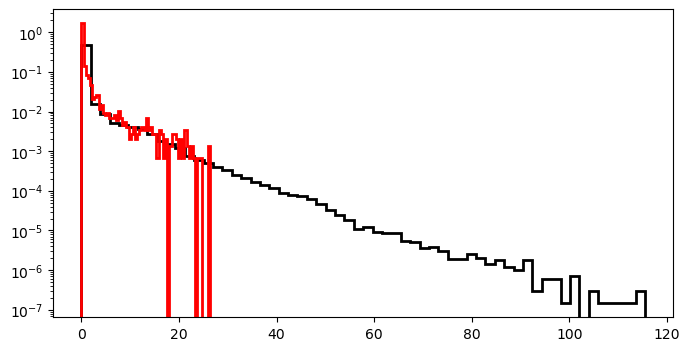

19.299243259429957
17.319992713928254


In [67]:
fig = plt.figure(figsize=(8,4)) #,layout="constrained")
gs = gridspec.GridSpec(1,1)

day = 6
tindex = (day -1)*4
expn=3 

x2  =ds_red[experiments[expn]].isel(time= tindex)
x80 =ds_red[experiments[expn+6]].isel(time= tindex)


#x2=ds_red[experiments2[0]]
ax1=plt.subplot(gs[0])
                            
plt.hist(x2['prec_6hrly'],  60, histtype='step', edgecolor='k',lw=2, density=True)
plt.hist(x80['prec_6hrly'], 60, histtype='step', edgecolor='r',lw=2, density=True)
#plt.hist(x80['prec_6hrly'],60, fill=False, edgecolor='r',lw=2)
ax1.set_yscale("log")
#ax1.set_xlim([0,15])
plt.show()
pext   = np.percentile(x2['prec_6hrly'],99)
print(pext)
pext   = np.percentile(x80['prec_6hrly'],99)
print(pext)

In [100]:
perc=99
tp_ext     = {}
wdsp_ext   = {}
tp_avg     = {}
wdsp_avg   = {}

deeprate   = {}
tpavg_change   = {}
wdspavg_change = {}
for exp in experiments:
    wdspext  = np.full(len(track_dur[exp]),np.nan,dtype=float)
    tpext    = np.full(len(track_dur[exp]),np.nan,dtype=float)
    wdspavg  = np.full(len(track_dur[exp]),np.nan,dtype=float)
    tpavg    = np.full(len(track_dur[exp]),np.nan,dtype=float)
    
    deeprate0= np.full(len(track_dur[exp]),np.nan,dtype=float)
    pmin  = track_pmin[exp].to_numpy()
    for tindex in np.arange(8,32,1):  
        #lon1 = track_lon[exp][tindex]-20
        #lon2 = track_lon[exp][tindex]+20
        #print(lon1, lon2)
        #lat1 = track_lat[exp][tindex]-20
        #lat2 = track_lat[exp][tindex]+20
        x = ds_red[exp].isel(time= tindex)
        y = ds_concat[exp].isel(time= tindex)
        #x0  = reduce_lonrange(x00, lon1, lon2)
        #x   = reduce_latrange(x0,  lat1, lat2)
        #y0  = reduce_lonrange(y00, lon1, lon2)
        #y   = reduce_latrange(y0,  lat1, lat2)
        tpext[tindex]   = np.percentile(x['prec_6hrly'],perc)
        wdspext[tindex] = np.percentile(y['wind_10m'],perc)
        tpavg[tindex]   = np.average(x['prec_6hrly'])
        wdspavg[tindex] = np.average(y['wind_10m'])   
        
        deeprate0[tindex] = (pmin[tindex+1]-pmin[tindex])
    
    tp_ext[exp] = tpext
    wdsp_ext[exp] = wdspext
    tp_avg[exp] = tpavg
    wdsp_avg[exp] = wdspavg
    deeprate[exp] = deeprate0
    
    tpavg_cha   = np.full(len(track_dur[exp]),np.nan,dtype=float)
    wdspavg_cha = np.full(len(track_dur[exp]),np.nan,dtype=float)
    for t in np.arange(8,32,1):  
        tpavg_cha[t]   = tpavg[t]-tpavg[t-1]
        wdspavg_cha[t] = wdspavg[t]-wdspavg[t-1]
        
    tpavg_change[exp]   = tpavg_cha
    wdspavg_change[exp] = wdspavg_cha
    
print(tp_ext['channel_2km_0002'])
print(tp_ext['channel_80km_0002'])

[        nan         nan         nan         nan         nan         nan
         nan         nan  0.27556564  1.50254611  3.37464004  6.3713917
 11.52489147 21.0923934  17.14502926 16.69067507 17.40467796 17.05589495
 16.12845678 18.0793828  21.71660986 20.60366879 18.94134903 19.07348948
 17.63042164 17.94488106 16.68990746 14.99450455 12.65478148 10.9152236
 10.68554392  9.91435962         nan         nan         nan         nan
         nan]
[        nan         nan         nan         nan         nan         nan
         nan         nan  1.738526    2.04398643  2.1587415   4.34345625
  6.16711157 10.96224218 13.39246243 14.21906194 14.45468257 14.06930465
 13.45159665 15.98821978 20.36555256 21.32491297 18.3612528  17.27627632
 17.23140675 17.19373566 16.07787703 13.80293714 13.99113648 16.42475161
 14.52015945 11.82662333         nan         nan         nan         nan
         nan]


channel_80km_0001
maximum wdsp_avg: 13.392496109008789
maximum tp_avg: 0.975048840045929
channel_80km_0002
maximum wdsp_avg: 13.103495597839355
maximum tp_avg: 1.2461038827896118
channel_80km_0003
maximum wdsp_avg: 13.050339698791504
maximum tp_avg: 1.1461495161056519
channel_80km_0004
maximum wdsp_avg: 12.582961082458496
maximum tp_avg: 1.2483160495758057
channel_2km_0001
maximum wdsp_avg: 13.170534133911133
maximum tp_avg: 1.0249955654144287
channel_2km_0002
maximum wdsp_avg: 12.345197677612305
maximum tp_avg: 1.2749619483947754
channel_2km_0003
maximum wdsp_avg: 12.725811004638672
maximum tp_avg: 1.1927599906921387
channel_2km_0004
maximum wdsp_avg: 12.167366981506348
maximum tp_avg: 1.274874210357666
channel_80km_0001
maximum wdsp_ext: 22.18031120300293
maximum tp_ext: 13.708297281265278
channel_80km_0002
maximum wdsp_ext: 22.984098434448242
maximum tp_ext: 21.324912967681897
channel_80km_0003
maximum wdsp_ext: 22.20864486694336
maximum tp_ext: 14.690996637344364
channel_80km_0004


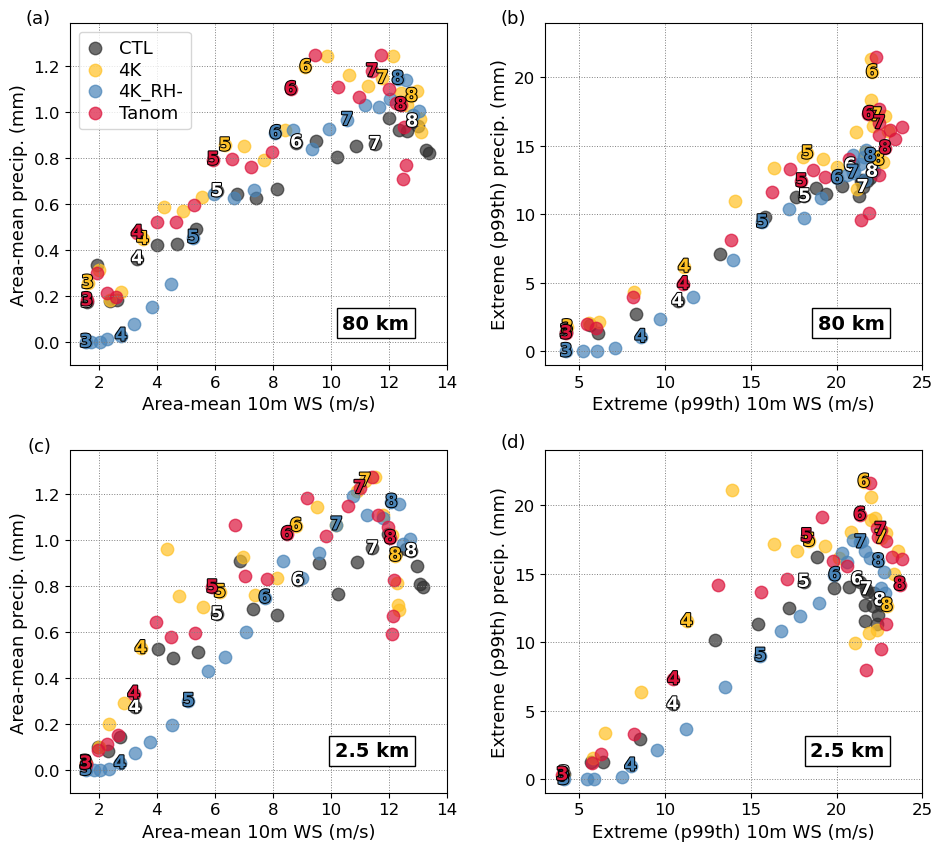

In [128]:
import matplotlib.patheffects as pe
#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
#colors={1:'dimgray',2:'gold',3:'royalblue',4:'crimson',5:'darkorange',6:'mediumseagreen'}

colors2={0:'white',1:'#FFC125',2:'#4984b8',3:'crimson',4:'yellowgreen',5:'mediumpurple'}

#colors={1:'k',2:'#FFC125',3:'#4984b8',4:'crimson',5:'gold',6:'mediumseagreen'}
colors={0:'#303030',1:'#FFC125',2:'#4984b8',3:'crimson',4:'yellowgreen',5:'mediumpurple'}

colorsedge={0:'k',1:'k',2:'k',3:'k',4:'k',5:'k',6:'k'}
#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}

fs=13

expname = ['CTL', '4K', '4K_RH-','Tanom','T+TRanom','T+POanom']

plt.rcParams['savefig.facecolor']='white'


fig = plt.figure(figsize=(11, 10))


ax1 = plt.subplot(2,2,1)


#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(6,10,1):
#for i in [1,4,5,6]:
    print(experiments[i])
    print ('maximum wdsp_avg:', np.nanmax(wdsp_avg[experiments[i]]))
    print ('maximum tp_avg:', np.nanmax(tp_avg[experiments[i]]))
    plt.scatter(wdsp_avg[experiments[i]],tp_avg[experiments[i]],#s=(track_dp[exp80[i]][2:26]-920)*2,
                s=80,
                c=colors[i-6], label=expname[i-6], vmin=0, vmax=8, marker='o',alpha=0.7) 
    
    #print(track_dur[experiments[i]])
    for jj in range(len(wdsp_avg[experiments[i]][8:32:4])):
        #print(jj)
        plt.annotate(''+str('{:01.0f}'.format(track_dur[experiments[i]][8+jj*4]))+'', (wdsp_avg[experiments[i]][8+jj*4], tp_avg[experiments[i]][8+jj*4]),
                        color=colors2[i-6],ha='center',va='center',fontsize=fs,fontweight='bold', zorder=500,
                        path_effects=[pe.withStroke(linewidth=1.5, foreground=colorsedge[i-6])])
    
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Area-mean precip. (mm)',fontsize=13)
#plt.xlabel('P98th 850-hPa wdsp (m/s)',fontsize=13)
plt.xlabel('Area-mean 10m WS (m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('80 km', fontsize=14, y=0.99)
plt.ylim(-0.1, 1.39)
plt.xlim(1, 14)
plt.legend(loc="upper left",fontsize=13,handlelength=1.0,labelspacing=0.2)
plt.text(0.9, 0.15,
         '80 km',ha='right',va='top', 
         weight='bold',fontsize=14,
         bbox=dict(ec='k',fc='white'),
                 transform=ax1.transAxes, zorder=50)
#plt.text(0.9, 0.15, '80 km', ha='right', va='top', transform=ax1.transAxes, fontsize=15, color='dimgray',fontweight='bold') 
plt.text(-0.05, 1.04, '(a)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 

#=============================
ax2 = plt.subplot(2,2,3)    
#for i in [1,4,5,6]:
for i in range(0,4,1):
    print(experiments[i])
    print ('maximum wdsp_avg:', np.nanmax(wdsp_avg[experiments[i]]))
    print ('maximum tp_avg:', np.nanmax(tp_avg[experiments[i]]))
    plt.scatter(wdsp_avg[experiments[i]],tp_avg[experiments[i]],#s=(track_dp[exp80[i]][2:26]-920)*2,
                s=80,
                c=colors[i], label=expname[i], vmin=0, vmax=8, marker='o',alpha=0.7) 
    
    #print(track_dur[experiments[i]])
    for jj in range(len(wdsp_avg[experiments[i]][8:32:4])):
        plt.annotate(''+str('{:01.0f}'.format(track_dur[experiments[i]][8+jj*4]))+'', (wdsp_avg[experiments[i]][8+jj*4], tp_avg[experiments[i]][8+jj*4]),
                        color=colors2[i],ha='center',va='center',fontsize=fs,fontweight='bold', zorder=500,
                        path_effects=[pe.withStroke(linewidth=1.5, foreground=colorsedge[i])])



plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(-0.1, 1.39)
plt.xlim(1, 14)
plt.ylabel('Area-mean precip. (mm)',fontsize=13)
#plt.xlabel('P98th 850-hPa wdsp (m/s)',fontsize=13)
plt.xlabel('Area-mean 10m WS (m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('2 km', fontsize=14,  y=0.99)
plt.text(0.9, 0.15,
         '2.5 km',ha='right',va='top', 
         weight='bold',fontsize=14,
         bbox=dict(ec='k',fc='white'),
                 transform=ax2.transAxes, zorder=50)
#plt.text(0.9, 0.15, '2 km', ha='right', va='top', transform=ax2.transAxes, fontsize=15, color='dimgray',fontweight='bold') 
plt.text(-0.05, 1.04, '(c)', ha='right', va='top', transform=ax2.transAxes, fontsize=13) 

#=============================
ax1 = plt.subplot(2,2,2)

#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(6,10,1):
#for i in [4]:
    print(experiments[i])
    print ('maximum wdsp_ext:', np.nanmax(wdsp_ext[experiments[i]]))
    print ('maximum tp_ext:', np.nanmax(tp_ext[experiments[i]]))
    plt.scatter(wdsp_ext[experiments[i]],tp_ext[experiments[i]],#s=(track_dp[exp80[i]][2:26]-920)*2,
                s=80,
                c=colors[i-6], label=expname[i-6], vmin=0, vmax=8, marker='o',alpha=0.7) 
    
    #print(track_dur[experiments[i]])
    for jj in range(len(wdsp_avg[experiments[i]][8:32:4])):
        #print(jj)
        plt.annotate(''+str('{:01.0f}'.format(track_dur[experiments[i]][8+jj*4]))+'', (wdsp_ext[experiments[i]][8+jj*4], tp_ext[experiments[i]][8+jj*4]),
                        color=colors2[i-6],ha='center',va='center',fontsize=fs,fontweight='bold', zorder=500,
                        path_effects=[pe.withStroke(linewidth=1.5, foreground=colorsedge[i-6])])
        
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Extreme (p99th) precip. (mm)',fontsize=13)
plt.xlabel('Extreme (p99th) 10m WS (m/s)',fontsize=13)
#plt.xlabel('Averaged 850-hPa wdsp',fontsize=13)

plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('80 km', fontsize=14,  y=0.99)

#plt.ylim(-1, 21)
plt.ylim(-1, 24)
plt.xlim(3, 25)
plt.xticks([5,10,15,20,25])
#plt.legend(loc="upper left",fontsize=13)
plt.text(0.9, 0.15,
         '80 km',ha='right',va='top', 
         weight='bold',fontsize=14,
         bbox=dict(ec='k',fc='white'),
                 transform=ax1.transAxes, zorder=50)
#plt.text(0.9, 0.15, '80 km', ha='right', va='top', transform=ax1.transAxes, fontsize=15, color='dimgray',fontweight='bold') 
plt.text(-0.05, 1.04, '(b)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 

#=============================
ax2 = plt.subplot(2,2,4)    
for i in range(0,4,1):
#for i in [1,4,5,6]:
    print(experiments[i])
    print ('maximum wdsp_ext:', np.nanmax(wdsp_ext[experiments[i]]))
    print ('maximum tp_ext:', np.nanmax(tp_ext[experiments[i]]))
    plt.scatter(wdsp_ext[experiments[i]],tp_ext[experiments[i]],#s=(track_dp[exp80[i]][2:26]-920)*2,
                s=80,
                c=colors[i], label=expname[i], vmin=0, vmax=8, marker='o',alpha=0.7) 
    
    #print(track_dur[experiments[i]])
    for jj in range(len(wdsp_avg[experiments[i]][8:32:4])):
        #print(jj)
        plt.annotate(''+str('{:01.0f}'.format(track_dur[experiments[i]][8+jj*4]))+'', (wdsp_ext[experiments[i]][8+jj*4], tp_ext[experiments[i]][8+jj*4]),
                        color=colors2[i],ha='center',va='center',fontsize=fs,fontweight='bold', zorder=500,
                        path_effects=[pe.withStroke(linewidth=1.5, foreground=colorsedge[i])])
        
    
    #plt.text(wdsp_avg[exp2[i]][2:26:4],tp_avg[exp2[i]][2:26:4]+0.25,'test')
             #''+str(track_time[exp2[i]][2:26:4])+'', 
    #                    color=colors[i],ha='center',va='center',fontsize=13, zorder=500)
#ax2.legend()

#plt.legend(handles=scatter.legend_elements(prop="colors"), loc="upper left")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-1, 24)
plt.xlim(3, 25)
plt.xticks([5,10,15,20,25])
#plt.xlim(0.8, 10.1)
plt.ylabel('Extreme (p99th) precip. (mm)',fontsize=13)
plt.xlabel('Extreme (p99th) 10m WS (m/s)',fontsize=13)
#plt.xlabel('Averaged 850-hPa wdsp (m/s)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)

#plt.text(0.9, 0.15, '2 km', ha='right', va='top', transform=ax2.transAxes, fontsize=15, color='dimgray',fontweight='bold') 
plt.text(0.9, 0.15,
         '2.5 km',ha='right',va='top', 
         weight='bold',fontsize=14,
         bbox=dict(ec='k',fc='white'),
                 transform=ax2.transAxes, zorder=50)
plt.text(-0.05, 1.05, '(d)', ha='right', va='top', transform=ax2.transAxes, fontsize=13) 

plt.subplots_adjust(wspace=0.26, hspace=0.25)
plt.savefig('Fig5_scatter_tp_10mwdsp_p99_and_avg_2km_vs_80km_EXP1-4_raw.png', bbox_inches='tight', dpi=100)

plt.show()
plt.close()

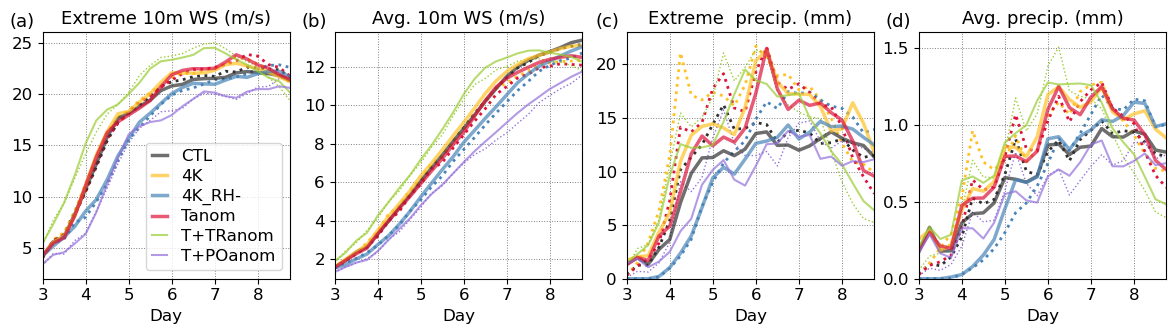

In [123]:
# FOR SUPPLEMENTARY MATERIAL ================================

#colors={1:'k',2:'gold',3:'mediumseagreen',4:'darkorange',5:'crimson',6:'royalblue'}
fs=12

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(14.5, 3.2))

ax1 = plt.subplot(1,4,1)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(0,6,1): # 2km
    if i > 3:
        plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    else: 
        plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1)
for i in range(6,12,1): # 80km
    if i > 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    else:
        plt.plot(track_dur[experiments[i]],wdsp_ext[experiments[i]],color=colors[i-6],linewidth=2.5,alpha=0.7,label=expname[i-6]) 
      
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(2,26)
plt.xlabel('Day',fontsize=12)
#plt.ylabel('(m/s)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Extreme 10m WS (m/s)', fontsize=13)
#plt.title('P98th 850-hPa wdsp in 40x40 domain', fontsize=14)
plt.text(-0.03, 1.08, '(a)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
plt.legend(loc="lower right",fontsize=12,labelspacing=0.28,handlelength=0.9)
ax1.xaxis.set_ticks(np.arange(3, 9, 1))

ax1 = plt.subplot(1,4,2)
for i in range(0,6,1): # 2km
    if i > 3:
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    else: 
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1)
for i in range(6,12,1): # 80km
    if i > 3+6:
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    else:
        plt.plot(track_dur[experiments[i]],wdsp_avg[experiments[i]],color=colors[i-6],linewidth=2.5,alpha=0.7,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(1,13.8)
plt.xlabel('Day',fontsize=12)
#plt.ylabel('(m/s)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Avg. 10m WS (m/s)', fontsize=13)
#plt.title('Averaged 850-m wdsp in 40x40 domain', fontsize=14)
plt.text(-0.03, 1.08, '(b)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))

ax1 = plt.subplot(1,4,3)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   
for i in range(0,6,1): # 2km
    if i > 3:
        plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    else: 
        plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1)
for i in range(6,12,1): # 80km
    if i > 3+6:
        plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    else:
        plt.plot(track_dur[experiments[i]],tp_ext[experiments[i]],color=colors[i-6],linewidth=2.5,alpha=0.7,label=expname[i-6]) 
        
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(0, 23)
plt.xlabel('Day',fontsize=12)
#plt.ylabel('(mm)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Extreme  precip. (mm)', fontsize=13)
plt.text(-0.03, 1.08, '(c)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))

ax1 = plt.subplot(1,4,4)
for i in range(0,6,1): # 2km
    if i > 3:
        plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=1.,linestyle=':',alpha=1)
    else: 
        plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i],linewidth=2.,linestyle=':',alpha=1)
for i in range(6,12,1): # 80km
    if i > 3+6:
        plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=1.5,alpha=0.7, label=expname[i-6]) 
    else:
        plt.plot(track_dur[experiments[i]],tp_avg[experiments[i]],color=colors[i-6],linewidth=2.5,alpha=0.7,label=expname[i-6]) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(3,8.75)
plt.ylim(0, 1.6)
plt.xlabel('Day',fontsize=12)
#plt.ylabel('(mm)',fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title('Avg. precip. (mm)', fontsize=13)
plt.text(-0.03, 1.08, '(d)', ha='right', va='top', transform=ax1.transAxes, fontsize=13) 
ax1.xaxis.set_ticks(np.arange(3, 9, 1))
ax1.yaxis.set_ticks(np.arange(0, 2.0, 0.5))

plt.subplots_adjust(hspace = 0.3, wspace=0.18)

#plt.title('Deepening rate of the cyclone center (Semi-Lagragian)', fontsize=14)
plt.savefig('FigS_TP_10mWDSP_p99_and_avg_2km80km_allsims_raw.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()

Pearsons correlation: 0.350
Spearmans correlation: 0.361
R-squared: 0.122618
Pearsons correlation: 0.630
Spearmans correlation: 0.603
R-squared: 0.397204


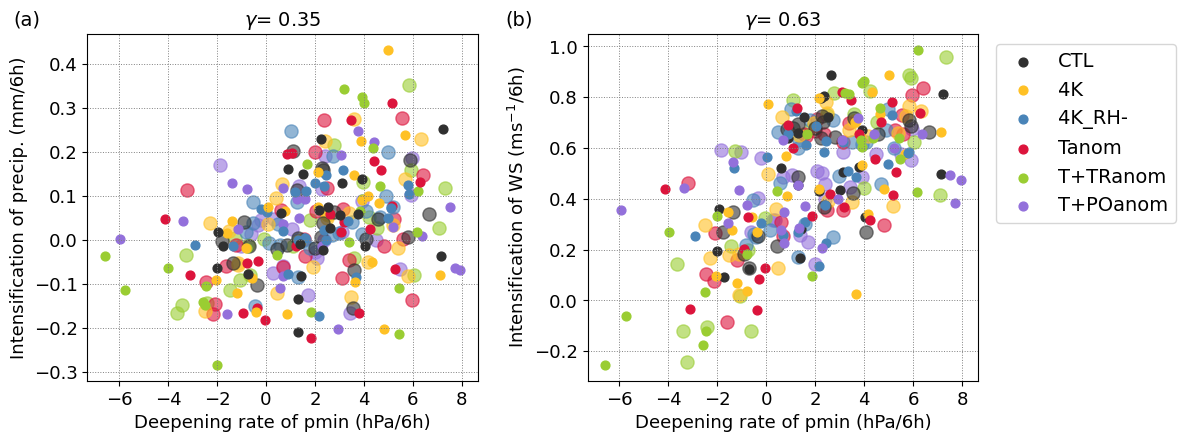

In [126]:
from scipy.stats import pearsonr, spearmanr, linregress

fs=10

plt.rcParams['savefig.facecolor']='white'
fig = plt.figure(figsize=(11.5, 4.5))

ax1 = plt.subplot(1,2,1)
#ax1.bar(time,precipsum1,width=0.2,color='cornflowerblue',label='80km',alpha=1)   

for i in range(11,5,-1): # 80km
    plt.scatter(-deeprate[experiments[i]],tpavg_change[experiments[i]],c=colors[i-6], s=90, marker='o',alpha=0.6) 
for i in range(5,-1,-1): # 2km
    plt.scatter(-deeprate[experiments[i]],tpavg_change[experiments[i]],c=colors[i], s=40, marker='o',alpha=1) 

deeprateavg_all=[]
tpavgchange_all=[]
# calculate Pearson's correlation
for i in range(0,12,1):
    deeprateavg_all.extend(-deeprate[experiments[i]][9:32])
    #print(deeprateavg_all)
    tpavgchange_all.extend(tpavg_change[experiments[i]][9:32])
corrp, _ = pearsonr(deeprateavg_all, tpavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, tpavgchange_all)
print('Spearmans correlation: %.3f' % corrs)

res = linregress(deeprateavg_all, tpavgchange_all)
print(f"R-squared: {res.rvalue**2:.6f}")
    #plt.plot(time,minmslp[exp2[i]]/100.,color=colors[i],linestyle=':',linewidth=2.5,alpha=1) 
#ax1.set_xlim(time[0],time[ntimes-1])
#ax1.set_ylabel('hPa',fontsize=fs)
#ax1.set_xticks(np.arange(3,10,1))
#ax1.set_ylim(0,1.3)
#plt.xticks(np.arange(1,11,1))
#plt.legend(fontsize=fs)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim(-0.35, 0.45)
#plt.xlim(0.8, 10.1)
plt.xlabel('Deepening rate of pmin (hPa/6h)',fontsize=13)
plt.ylabel('Intensification of precip. (mm/6h)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
#plt.title('Minimum mslp in the domain', fontsize=14)
#plt.savefig('Rawdata_domain_pmin_2km_vs_80km.png', bbox_inches='tight', dpi=100)
plt.title(''r'$\gamma$= %.2f' % corrp, fontsize=14)
plt.text(-0.12, 1.07, '(a)', ha='right', va='top', transform=ax1.transAxes, fontsize=14) 

ax1 = plt.subplot(1,2,2)

for i in range(11,5,-1): # 80km
    plt.scatter(-deeprate[experiments[i]],wdspavg_change[experiments[i]],c=colors[i-6], vmin=0, vmax=8, s=90, marker='o',alpha=0.6) 
for i in range(0,6,1): # 2km
    plt.scatter(-deeprate[experiments[i]],wdspavg_change[experiments[i]],c=colors[i], vmin=0, vmax=8, s=40, marker='o',alpha=1,label=expname[i]) 
    
ax1.legend(fontsize=14, columnspacing=0.,bbox_to_anchor=(1.53, 1))

wdspavgchange_all=[]
# calculate Pearson's correlation
for i in range(0,12,1):
    wdspavgchange_all.extend(wdspavg_change[experiments[i]][9:32])
corrp, _ = pearsonr(deeprateavg_all, wdspavgchange_all)
print('Pearsons correlation: %.3f' % corrp)
corrs, _ = spearmanr(deeprateavg_all, wdspavgchange_all)
print('Spearmans correlation: %.3f' % corrs)
res = linregress(deeprateavg_all, wdspavgchange_all)
print(f"R-squared: {res.rvalue**2:.6f}")
    #plt.plot(time,minmslp[exp2[i]]/100.,color=colors[i],linestyle=':',linewidth=2.5,alpha=1) 
#ax1.set_xlim(time[0],time[ntimes-1])
#ax1.set_ylabel('hPa',fontsize=fs)
#ax1.set_xticks(np.arange(3,10,1))
#ax1.set_ylim(-0.8,1.35)
#plt.xticks(np.arange(1,11,1))
#plt.legend(fontsize=fs)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim(932, 1004)
#plt.xlim(0.8, 10.1)
plt.xlabel('Deepening rate of pmin (hPa/6h)',fontsize=13)
plt.ylabel('Intensification of WS (m'r'$\mathrm{s}^{-1}$''/6h)',fontsize=13)
plt.grid(color='gray', linestyle=':', linewidth=0.7)
plt.title(''r'$\gamma$= %.2f' % corrp, fontsize=14)


plt.text(-0.14, 1.07, '(b)', ha='right', va='top', transform=ax1.transAxes, fontsize=14) 

plt.subplots_adjust(wspace = 0.28)


plt.savefig('FigS_DeepeningrateLagrangian_averaged_precipitation_10mwdsp_change_relation_raw.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()